In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from utils import accuracy
from get_dataset import get_cifar100_data_loaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CIFAR-100 数据加载器
cifar100_train_loader, cifar100_test_loader = get_cifar100_data_loaders(batch_size=256)

def finetune_resnet18(model, train_loader, test_loader, epochs=15, lr=0.0005, weight_decay=0.0):
    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Linear(512, 100)
    for param in model.fc.parameters():
        param.requires_grad = True
        
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    top1_train_accuracy_list = []
    top1_accuracy_list = []
    top5_accuracy_list = []
    epoch_list = []
    train_loss_list = []
    test_loss_list = []

    for epoch in range(epochs):
        model.train()
        top1_train_accuracy = 0
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            top1 = accuracy(logits, y_batch, topk=(1,))
            top1_train_accuracy += top1[0]

        top1_train_accuracy /= len(train_loader)
        train_loss /= len(train_loader)
        
        model.eval()
        top1_accuracy = 0
        top5_accuracy = 0
        test_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                logits = model(x_batch)
                loss = criterion(logits, y_batch)
                test_loss += loss.item()
                top1, top5 = accuracy(logits, y_batch, topk=(1, 5))
                top1_accuracy += top1[0]
                top5_accuracy += top5[0]

        top1_accuracy /= len(test_loader)
        top5_accuracy /= len(test_loader)
        test_loss /= len(test_loader)

        top1_train_accuracy_list.append(top1_train_accuracy.item())
        top1_accuracy_list.append(top1_accuracy.item())
        top5_accuracy_list.append(top5_accuracy.item())
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        epoch_list.append(epoch + 1)
        
        print(f"Epoch {epoch}\tTop1 Train accuracy: {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 Test accuracy: {top5_accuracy.item()}\tTrain loss: {train_loss}\tTest loss: {test_loss}")

    return top1_train_accuracy_list, top1_accuracy_list, top5_accuracy_list, train_loss_list, test_loss_list, epoch_list


In [2]:

# 加载ImageNet预训练的ResNet-18
imagenet_resnet18 = torchvision.models.resnet18(pretrained=True)

# 微调 ImageNet 预训练的 ResNet-18
imagenet_top1_train_accuracy, imagenet_top1_test_accuracy, imagenet_top5_test_accuracy, imagenet_train_loss, imagenet_test_loss, epoch_list = finetune_resnet18(
    imagenet_resnet18, cifar100_train_loader, cifar100_test_loader)


/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(

Epoch 0	Top1 Train accuracy: 12.823262214660645	Top1 Test accuracy: 20.185546875	Top5 Test accuracy: 43.5546875	Train loss: 4.001799864428384	Test loss: 3.5714155793190003
Epoch 1	Top1 Train accuracy: 22.587690353393555	Top1 Test accuracy: 23.173828125	Top5 Test accuracy: 48.49609375	Train loss: 3.3759541669670416	Test loss: 3.357982486486435
Epoch 2	Top1 Train accuracy: 25.6564884185791	Top1 Test accuracy: 24.619140625	Top5 Test accuracy: 50.654296875	Train loss: 3.1768021911990885	Test loss: 3.2712060868740083
Epoch 3	Top1 Train accuracy: 27.39158058166504	Top1 Test accuracy: 25.439453125	Top5 Test accuracy: 51.69921875	Train loss: 3.0630639475219104	Test loss: 3.225454956293106
Epoch 4	Top1 Train accuracy: 28.672273635864258	Top1 Test accuracy: 26.044921875	Top5 Test accuracy: 52.265625	Train loss: 2.9850984714469133	Test loss: 3.198559933900833
Epoch 5	Top1 Train accuracy: 29.666772842407227	Top1 Test accuracy: 26.337890625	Top5 Test accuracy: 52.744140625	Train loss: 2.92649579899

In [3]:
# 加载通过自监督学习训练的 ResNet-18
checkpoint_path = '/root/Lab3-1/logs/simclr_TIN_lr0.001_wd0_temp0.07_bt512_e500/checkpoint_0400.pth.tar'
ssl_resnet18 = torchvision.models.resnet18(pretrained=False)
ssl_resnet18.fc = torch.nn.Linear(512, 100)  
checkpoint = torch.load(checkpoint_path, map_location=device)

# 加载自监督预训练权重
state_dict = checkpoint['state_dict']
for k in list(state_dict.keys()):
    if k.startswith('backbone.') and not k.startswith('backbone.fc'):
        state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]
ssl_resnet18.load_state_dict(state_dict, strict=False)

# 微调通过自监督学习训练的 ResNet-18
ssl_top1_train_accuracy, ssl_top1_test_accuracy, ssl_top5_test_accuracy, ssl_train_loss, ssl_test_loss, _ = finetune_resnet18(
    ssl_resnet18, cifar100_train_loader, cifar100_test_loader)

/usr/local/miniconda3/envs/CV/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0	Top1 Train accuracy: 17.90656852722168	Top1 Test accuracy: 24.912109375	Top5 Test accuracy: 52.109375	Train loss: 3.6088609415657666	Test loss: 3.1695007264614103
Epoch 1	Top1 Train accuracy: 27.188695907592773	Top1 Test accuracy: 28.046875	Top5 Test accuracy: 55.4296875	Train loss: 3.0312962300923405	Test loss: 3.0020209729671476
Epoch 2	Top1 Train accuracy: 29.786352157592773	Top1 Test accuracy: 29.287109375	Top5 Test accuracy: 57.08984375	Train loss: 2.8825296297365304	Test loss: 2.9294490218162537
Epoch 3	Top1 Train accuracy: 31.357221603393555	Top1 Test accuracy: 29.90234375	Top5 Test accuracy: 57.87109375	Train loss: 2.793022935487786	Test loss: 2.8849361419677733
Epoch 4	Top1 Train accuracy: 32.59885025024414	Top1 Test accuracy: 30.5078125	Top5 Test accuracy: 58.59375	Train loss: 2.7273987604647267	Test loss: 2.8535517334938048
Epoch 5	Top1 Train accuracy: 33.51283264160156	Top1 Test accuracy: 31.005859375	Top5 Test accuracy: 59.150390625	Train loss: 2.6750861540132638	T

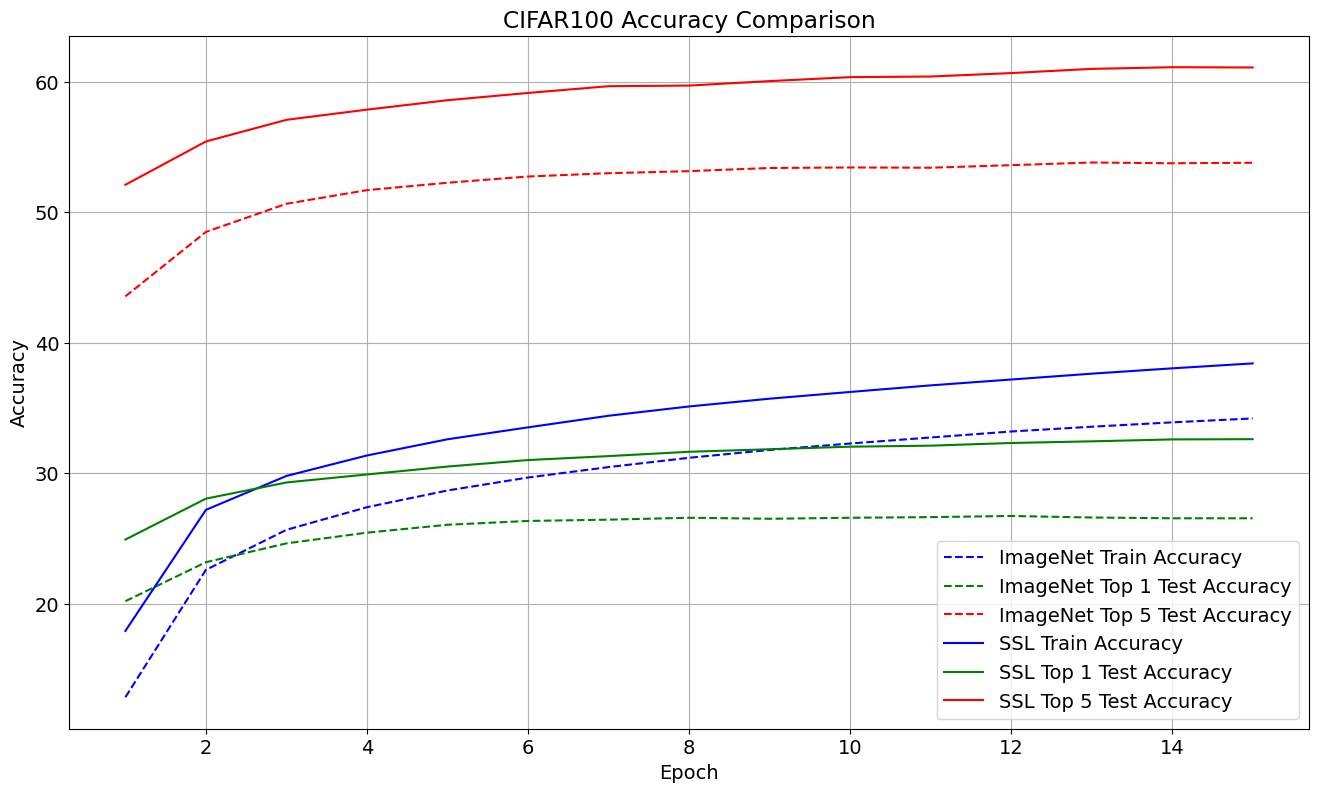

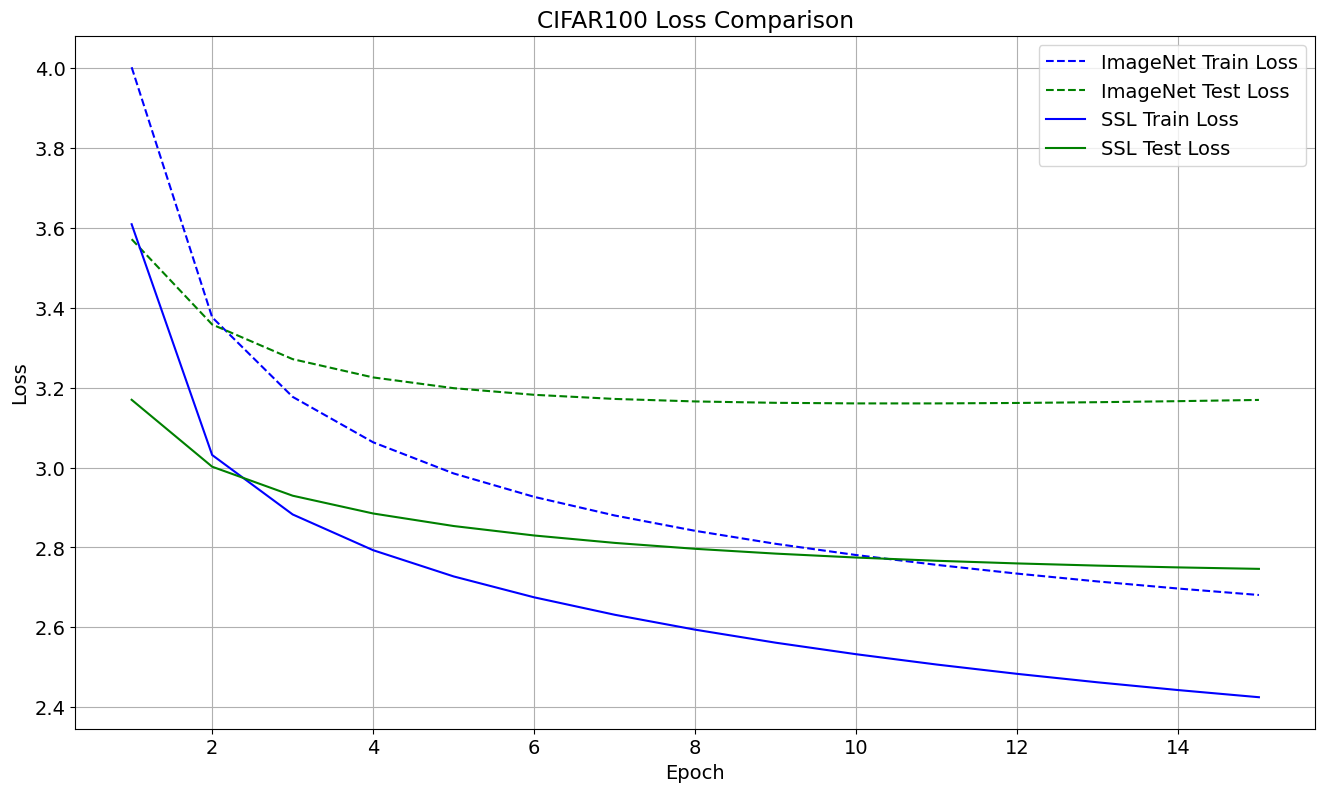

In [4]:

# 绘制 Accuracy 图
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Accuracy Comparison')
plt.plot(epoch_list, imagenet_top1_train_accuracy, c='b', linestyle='--')
plt.plot(epoch_list, imagenet_top1_test_accuracy, c='g', linestyle='--')
plt.plot(epoch_list, imagenet_top5_test_accuracy, c='r', linestyle='--')
plt.plot(epoch_list, ssl_top1_train_accuracy, c='b')
plt.plot(epoch_list, ssl_top1_test_accuracy, c='g')
plt.plot(epoch_list, ssl_top5_test_accuracy, c='r')
plt.legend(['ImageNet Train Accuracy', 'ImageNet Top 1 Test Accuracy', 'ImageNet Top 5 Test Accuracy',
            'SSL Train Accuracy', 'SSL Top 1 Test Accuracy', 'SSL Top 5 Test Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# 绘制 Loss 图
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Loss Comparison')
plt.plot(epoch_list, imagenet_train_loss, c='b', linestyle='--')
plt.plot(epoch_list, imagenet_test_loss, c='g', linestyle='--')
plt.plot(epoch_list, ssl_train_loss, c='b')
plt.plot(epoch_list, ssl_test_loss, c='g')
plt.legend(['ImageNet Train Loss', 'ImageNet Test Loss',
            'SSL Train Loss', 'SSL Test Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()